A great commentator shows excitement, emotion, and attention invested in the game. A poor commentator likely is emotionless and can decrease the fan experience of watching games.  In this notebook, we aim to grade excitement levels of the commentators in our data.

Instead of using the NLI-based zero-shot classifier, we can try a pretrained emotion classification model that is even fine-tuned on detecting emoptions. \

Pretrained models, such as `j-hartmann/emotion-english-distillroberta-base`, are finetuned to capture emotional moods such as happiness, sadness, fear, neglest, etc.  The model is specifically trained for emotion detection.  It's also 'distilled' meaning lighter weight than some comparable others.  We want to find commentator excitement and lack thereof to score the commentators.  A mundane broadcast is likely to decrease fan engagement and will result in a lower score.



In [34]:
# First, set Keras backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Install required packages
# !pip install -U transformers
# !pip install torch
# !pip install scipy  # for find_peaks

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import re
from scipy.signal import find_peaks

# Install required packages (run these if needed)
# !pip install -U transformers
# !pip install -U tensorflow
# !pip install -U torch
# !pip install hf_xet
# !pip install tf-keras

Let's add our data from our preproccessed notebook in this repo.

In [35]:
# load my data post-processed
data = pd.read_json("../dataset/preprocessed_data_full.json")

In [36]:
data.head()

,game_id,teams,transcript,year,tokens,doc_embedding,broadcaster
0,1962-houston_oilers-dallas_texans.txt,"[houston_oilers, dallas_texans]",gilson well defend the goal on your left theyl...,1962,"[gilson, well, defend, the, goal, on, your, le...","[0.0272845495, 0.0167274754, 0.0260243993, 0.0...",ABC
1,1969-chicago_bears-green_bay_packers.txt,"[chicago_bears, green_bay_packers]",cbs television sports presents the national fo...,1969,"[cbs, television, sports, presents, the, natio...","[0.0302205924, 0.014963325100000001, 0.0228471...",CBS
2,1969-cleveland_browns-minnesota_vikings-1.txt,"[cleveland_browns, minnesota_vikings]",the nfl today brought to you by the foundation...,1969,"[the, nfl, today, brought, to, you, by, the, f...","[0.027876755200000002, 0.0162593126, 0.0226585...",CBS
3,1969-cleveland_browns-minnesota_vikings.txt,"[cleveland_browns, minnesota_vikings]",the nfl today brought to you by the foundation...,1969,"[the, nfl, today, brought, to, you, by, the, f...","[0.028167814000000003, 0.016339412, 0.02250985...",CBS
4,1969-new_york_jets-baltimore_colts.txt,"[new_york_jets, baltimore_colts]",&gt;&gt; nbc sports presents the third nflafl ...,1969,"[gtgt, nbc, sports, presents, the, third, nfla...","[0.0310913976, 0.0153203607, 0.024078829200000...",NBC


In [37]:
emotion_classifier = pipeline(
    task="text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)


Device set to use mps:0
/Users/tommayer/.pyenv/versions/3.12.6/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [38]:
def excite(row):
    """ detect excitement in the game transcript """
    try:
        labels = ['joy', 'surprise']
        transcript = str(row['transcript'])
        
        # Break into chunks
        chunk_size = 256
        chunks = [transcript[i:i+chunk_size] for i in range(0, len(transcript), chunk_size)]
        
        # Process these chunks
        emotion_scores = []
        for chunk in chunks:
            try:
                results = emotion_classifier(chunk)
                scores = results[0]
                excitement_score = sum(
                    score['score'] for score in scores 
                    if score['label'] in labels
                )
                emotion_scores.append(excitement_score)
            except Exception as e:
                continue

        # Calculate metrics
        avg_emotion = np.mean(emotion_scores) if emotion_scores else 0
        max_emotion = max(emotion_scores) if emotion_scores else 0
        
        # detect excitement peaks
        if len(emotion_scores) > 1:
            min_distance = max(1, len(emotion_scores)//10)
            peaks, _ = find_peaks(emotion_scores, distance=min_distance)
            excitement_moments = len(peaks)
        else:
            excitement_moments = 0
        
        # Calculate composite excitement score
        excitement_score = np.mean([
            avg_emotion * 0.4,
            max_emotion * 0.4,
            (excitement_moments/10) * 0.2
        ])
        
        return {
            'game_id': row['game_id'],
            'year': row['year'],
            'teams': row['teams'],
            'broadcaster': row['broadcaster'],
            'excitement_score': excitement_score,
            'emotion_score': avg_emotion,
            'max_emotion': max_emotion,
            'excitement_peaks': excitement_moments,
            'excitement_timeline': emotion_scores
        }
    
    except Exception as e:
        print(f"Error processing game {row['game_id']}: {str(e)}")
        return None


In [39]:
def get_excitement(data):
    """
    Process all games in the DataFrame
    """
    results = []
    
    print(f"Starting analysis of {len(data)} games...")
    
    for idx, row in data.iterrows():
        result = excite(row)  # Pass the row, not the entire dataframe
        if result is not None:
            results.append(result)
            
        # Print progress every 10 games
        if len(results) % 10 == 0:
            print(f"Processed {len(results)} games...")
    
    return pd.DataFrame(results)

Now that we have the function to add our excitement score from our pretrained sentiment analyzer, let's apply it to our data.

In [40]:
# Run the analysis
print("Analyzing excitement levels in broadcasts...")
excitement_results = get_excitement(data)

# Display the results
print(f"\nAnalyzed {len(excitement_results)} games")
print("\nTop 5 most exciting games:")
top_exciting = excitement_results.sort_values(by='excitement_score', ascending=False).head(5)
print(top_exciting[['game_id', 'teams', 'broadcaster', 'excitement_score']])

print("\nBottom 5 least exciting games:")
bottom_exciting = excitement_results.sort_values(by='excitement_score').head(5)
print(bottom_exciting[['game_id', 'teams', 'broadcaster', 'excitement_score']])

Analyzing excitement levels in broadcasts...
Starting analysis of 1216 games...
Processed 10 games...
Processed 20 games...
Processed 30 games...
Processed 40 games...
Processed 50 games...
Processed 60 games...
Processed 70 games...
Processed 80 games...
Processed 90 games...
Processed 100 games...
Processed 110 games...
Processed 120 games...
Processed 130 games...
Processed 140 games...
Processed 150 games...
Processed 160 games...
Processed 170 games...
Processed 180 games...
Processed 190 games...
Processed 200 games...
Processed 210 games...
Processed 220 games...
Processed 230 games...
Processed 240 games...
Processed 250 games...
Processed 260 games...
Processed 270 games...
Processed 280 games...
Processed 290 games...
Processed 300 games...
Processed 310 games...
Processed 320 games...
Processed 330 games...
Processed 340 games...
Processed 350 games...
Processed 360 games...
Processed 370 games...
Processed 380 games...
Processed 390 games...
Processed 400 games...
Processed

Now that we have excitement levels, let's use weights to output overall scores.

We want to gauge how each broadcasting company does as a group! So, we'll bucket them together and get our average scores for each company.

In [41]:
def get_broadcaster_scores(excitement_results):
    """
    Calculate average excitement scores for each broadcaster
    """
    broadcaster_scores = {}
    
    for broadcaster in excitement_results['broadcaster'].unique():
        # Get all broadcasts for this broadcaster
        broadcaster_data = excitement_results[excitement_results['broadcaster'] == broadcaster]
        
        # Calculate statistics
        broadcaster_scores[broadcaster] = {
            'average_score': broadcaster_data['excitement_score'].mean(),
            'std_score': broadcaster_data['excitement_score'].std(),
            'num_broadcasts': len(broadcaster_data)
        }
    
    return broadcaster_scores

I'll plot the results so I can show readers how each company faired in terms of excitement!

In [42]:
def plot_broadcaster_scores(broadcaster_scores):
    """
    Create a horizontal bar plot of broadcaster excitement score rankings
    """
    # Create DataFrame for plotting
    scores_df = pd.DataFrame([
        {
            'broadcaster': broadcaster,
            'score': data['average_score'],
            'std': data['std_score'],
            'count': data['num_broadcasts']
        }
        for broadcaster, data in broadcaster_scores.items()
    ])
    
    # Sort by score
    scores_df = scores_df.sort_values('score', ascending=True)
    
    # Create horizontal bar plot with ranking
    plt.figure(figsize=(12, 6))
    bars = plt.barh(scores_df['broadcaster'], scores_df['score'], color='skyblue')
    
    # Add score values at the end of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                f'{scores_df["score"].iloc[i]:.3f} (n={scores_df["count"].iloc[i]})',
                va='center')

    
    plt.title('Broadcaster Excitement Score Rankings')
    plt.xlabel('Excitement Score')
    plt.xlim(0.2, 0.24)  # Set x-axis limits from 0.2 to 0.3
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

See below for broadcaster excitement scores:
ABC: 0.225 ± 0.007 (n=166)
CBS: 0.220 ± 0.008 (n=263)
NBC: 0.223 ± 0.008 (n=99)
FOX: 0.221 ± 0.008 (n=291)
ESPN: 0.224 ± 0.006 (n=397)


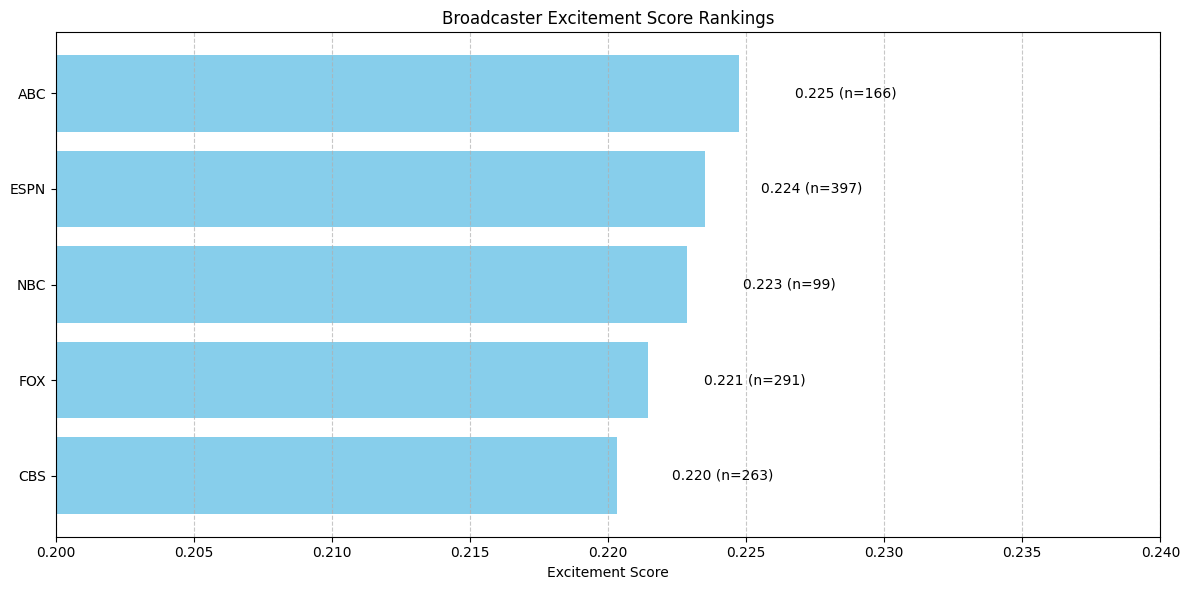

In [43]:
#call the functions here and print results
broadcaster_scores = get_broadcaster_scores(excitement_results)

print("See below for broadcaster excitement scores:")
for broadcaster, scores in broadcaster_scores.items(): # items returns a list of tuples
    print(f"{broadcaster}: {scores['average_score']:.3f} ± {scores['std_score']:.3f} (n={scores['num_broadcasts']})")

# Plot results
plot_broadcaster_scores(broadcaster_scores)